All the Jupyter Notebooks are available at https://github.com/neuro-ml/dpipe_tutorial

# Tutorials on Deep Pipe

The tutorials introduce the library called **Deep Pipe**, which is useful for medical image analysis, including preprocessing, data augmentation, performance validation and final prediction.

## Tutorial 2: Model initialization

In the current tutorial we build a tensorflow model for image segmentation and run it on a fake data. 

### Imports:

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# import deep pipe library
# how to install: https://github.com/neuro-ml/deep_pipe/blob/master/README.md
import dpipe

/nmnt/media/home/shmulev/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 0. Generate Fake Data:

To later test the process of model training, generate random data with random labels:

In [2]:
def generate_image(shape):
    return np.random.randn(*shape)[np.newaxis, ...]

def generate_label(shape):
    return np.random.randint(0, 2, size=shape)

def generate_dataset(size, shape):
    dataset = []
    labels = []
    for _ in range(size):
        dataset.append(generate_image(shape))
        labels.append(generate_label(shape))
        
    return dataset, labels

In [3]:
size = 200
shape = (28, 28)
data, labels = generate_dataset(size, shape)

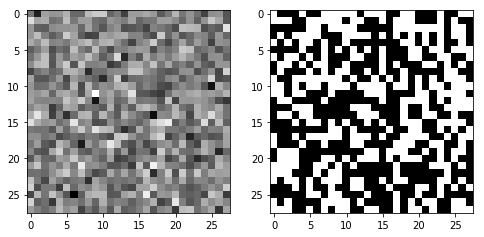

In [4]:
plt.figure(figsize=(2*4,2*4))
plt.subplot(121)
plt.imshow(data[-1][0,...], cmap='gray')
plt.subplot(122)
plt.imshow(labels[-1], cmap='gray')
plt.show()

### I. Model Core

A model core is exactly neural net which will later be used for computing logits, losses and making predictions. A model core must have the method `build`, which builds the computational graph along with placeholders and operations and returns the sequence of input placeholders and output logits. *The source: https://github.com/neuro-ml/deep_pipe/blob/develop/dpipe/model_core/base.py*

We can import UNet model:
*(see: https://github.com/neuro-ml/deep_pipe/blob/develop/dpipe/model_core/unet.py)*

In [5]:
from dpipe.model_core.unet import UNet2D

And initialize our `model_core` object:

In [6]:
unet = UNet2D(n_chans_in=1, n_chans_out=2, channels=[2])

`model_core` has method `build`, which builds computational graph and returns [x_ph], logits:

In [7]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        [x_ph], logits = unet.build(tf.placeholder('bool', name='is_training'))
        train_writer = tf.summary.FileWriter('train',
                                      sess.graph)

### II. TF Model

After we built our computational graph (we can compute logits!), we want to compute a certain loss, create a decision function, etc. Thus, we have to wrap our `model_core` net into another object called `model`, which attaches all the needed stuff (loss, optimizer, prediction function and so on).

Let's import it:

In [8]:
import dpipe.tf
from dpipe.tf.model import TFModel, TFFrozenModel

**TFModel** is the interface for training a neural network model.

Arguments:
- model_core: ModelCore,
- logits2pred: callable,
- logits2loss: callable, 
- optimize: callable

**TFFrozenModel** is the interface for making inference from already trained network.

Arguments:
- model_core: ModelCore,
- logits2pred: callable,
- restore_model_path

*For more detailts: https://github.com/neuro-ml/deep_pipe/blob/develop/dpipe/tf/model.py*

To initialize the models we have to pass several function (loss, prediction, optimizer). Let's import them from **dpipe.tf.utils**:

In [9]:
from dpipe.tf.utils import softmax_cross_entropy, softmax
from dpipe.tf.utils import get_tf_optimizer

Create optimizer function:

In [10]:
from functools import partial
optimize = partial(get_tf_optimizer, tf_optimizer_name='AdamOptimizer', beta1=0.899)

Initialize the model:

In [11]:
#reset the default graph to avoid the errors
tf.reset_default_graph()

tf_model = TFModel(unet, logits2pred=softmax, logits2loss=softmax_cross_entropy, optimize=optimize)
tf_model.session.close()

Instructions for updating:
Please switch to tf.train.get_or_create_global_step


### III. Methods of `TFModel` class

- `do_train_step(*train_inputs, lr)` - makes a training step for the given data, i.e. makes forward pass, computes the loss and make an weights update.
- `do_val_step(*val_inputs)` - makes a validation step for the given data, i.e. computes the loss and predictions. 
- `do_inf_step(*inference_inputs)` - makes a inference step for the given data, i.e. makes predictions.
- `save(path)` - saves the current session together with the trained model.
- `restore(path)` - restores some session

```loss = tf_model.do_train_step(*some_inputs, lr=some_lr)
y_pred, loss = tf_model.do_val_step(*some_inputs)
y_pred = tf_model.do_inf_step(*some_inputs)```

Run several train steps to track that our loss is decreasing:

In [12]:
n_steps = 1000
train_loss = []
val_loss = []

#reset the default graph to avoid the errors
tf.reset_default_graph()

tf_model = TFModel(unet, logits2pred=softmax, logits2loss=softmax_cross_entropy, optimize=optimize)

for i in range(n_steps):
    loss = tf_model.do_train_step(data[:100], labels[:100], lr=1e-3)
    train_loss.append(loss)
    print('%d-th step: loss = %f' % (i, loss))
    if i % 10 == 0:
        y_pred, loss = tf_model.do_val_step(data[100:], labels[100:])
        val_loss.extend([loss]*10)
        print('%d-th step: val. loss = %f' % (i, loss))
# after the training is done
tf_model.save('train')
tf_model.session.close()

0-th step: loss = 0.746419
0-th step: val. loss = 0.694547
1-th step: loss = 0.744972
2-th step: loss = 0.743591
3-th step: loss = 0.742278
4-th step: loss = 0.741036
5-th step: loss = 0.739844
6-th step: loss = 0.738689
7-th step: loss = 0.737568
8-th step: loss = 0.736483
9-th step: loss = 0.735433
10-th step: loss = 0.734408
10-th step: val. loss = 0.699508
11-th step: loss = 0.733412
12-th step: loss = 0.732444
13-th step: loss = 0.731503
14-th step: loss = 0.730603
15-th step: loss = 0.729727
16-th step: loss = 0.728863
17-th step: loss = 0.728019
18-th step: loss = 0.727189
19-th step: loss = 0.726369
20-th step: loss = 0.725565
20-th step: val. loss = 0.708092
21-th step: loss = 0.724763
22-th step: loss = 0.723977
23-th step: loss = 0.723210
24-th step: loss = 0.722456
25-th step: loss = 0.721712
26-th step: loss = 0.720981
27-th step: loss = 0.720268
28-th step: loss = 0.719573
29-th step: loss = 0.718899
30-th step: loss = 0.718234
30-th step: val. loss = 0.714133
31-th step:

259-th step: loss = 0.691196
260-th step: loss = 0.691190
260-th step: val. loss = 0.696061
261-th step: loss = 0.691183
262-th step: loss = 0.691177
263-th step: loss = 0.691171
264-th step: loss = 0.691165
265-th step: loss = 0.691160
266-th step: loss = 0.691154
267-th step: loss = 0.691148
268-th step: loss = 0.691142
269-th step: loss = 0.691136
270-th step: loss = 0.691131
270-th step: val. loss = 0.696008
271-th step: loss = 0.691125
272-th step: loss = 0.691120
273-th step: loss = 0.691114
274-th step: loss = 0.691109
275-th step: loss = 0.691103
276-th step: loss = 0.691098
277-th step: loss = 0.691093
278-th step: loss = 0.691088
279-th step: loss = 0.691083
280-th step: loss = 0.691078
280-th step: val. loss = 0.695938
281-th step: loss = 0.691073
282-th step: loss = 0.691068
283-th step: loss = 0.691062
284-th step: loss = 0.691057
285-th step: loss = 0.691052
286-th step: loss = 0.691047
287-th step: loss = 0.691042
288-th step: loss = 0.691037
289-th step: loss = 0.691032

530-th step: loss = 0.690185
530-th step: val. loss = 0.695797
531-th step: loss = 0.690181
532-th step: loss = 0.690178
533-th step: loss = 0.690174
534-th step: loss = 0.690171
535-th step: loss = 0.690167
536-th step: loss = 0.690164
537-th step: loss = 0.690161
538-th step: loss = 0.690157
539-th step: loss = 0.690154
540-th step: loss = 0.690151
540-th step: val. loss = 0.695809
541-th step: loss = 0.690148
542-th step: loss = 0.690145
543-th step: loss = 0.690142
544-th step: loss = 0.690139
545-th step: loss = 0.690136
546-th step: loss = 0.690133
547-th step: loss = 0.690130
548-th step: loss = 0.690127
549-th step: loss = 0.690125
550-th step: loss = 0.690122
550-th step: val. loss = 0.695819
551-th step: loss = 0.690120
552-th step: loss = 0.690117
553-th step: loss = 0.690114
554-th step: loss = 0.690111
555-th step: loss = 0.690108
556-th step: loss = 0.690105
557-th step: loss = 0.690102
558-th step: loss = 0.690100
559-th step: loss = 0.690097
560-th step: loss = 0.690094

803-th step: loss = 0.689453
804-th step: loss = 0.689451
805-th step: loss = 0.689449
806-th step: loss = 0.689447
807-th step: loss = 0.689446
808-th step: loss = 0.689444
809-th step: loss = 0.689442
810-th step: loss = 0.689440
810-th step: val. loss = 0.696422
811-th step: loss = 0.689438
812-th step: loss = 0.689436
813-th step: loss = 0.689434
814-th step: loss = 0.689432
815-th step: loss = 0.689430
816-th step: loss = 0.689428
817-th step: loss = 0.689426
818-th step: loss = 0.689424
819-th step: loss = 0.689422
820-th step: loss = 0.689419
820-th step: val. loss = 0.696445
821-th step: loss = 0.689417
822-th step: loss = 0.689415
823-th step: loss = 0.689412
824-th step: loss = 0.689410
825-th step: loss = 0.689408
826-th step: loss = 0.689405
827-th step: loss = 0.689403
828-th step: loss = 0.689401
829-th step: loss = 0.689398
830-th step: loss = 0.689396
830-th step: val. loss = 0.696466
831-th step: loss = 0.689393
832-th step: loss = 0.689391
833-th step: loss = 0.689388

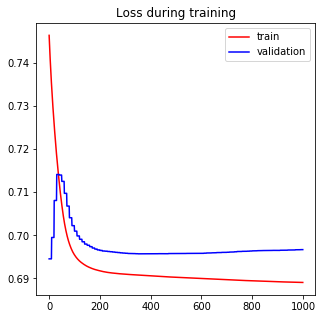

In [13]:
plt.figure(figsize=(5,5))
plt.plot(train_loss, 'r',label='train')
plt.plot(val_loss, 'b', label='validation')
plt.title('Loss during training')
plt.legend(loc='upper right')
plt.show()

After the training is done, we saved the model to `~/train` directory. We can restore that session and continue the training:

In [14]:
n_steps = 1000

#reset the default graph to avoid the errors
tf.reset_default_graph()

tf_model = TFModel(unet, logits2pred=softmax, logits2loss=softmax_cross_entropy, optimize=optimize)
tf_model.load('train')
for i in range(n_steps):
    loss = tf_model.do_train_step(data[:100], labels[:100], lr=1e-3)
    train_loss.append(loss)
    print('%d-th step: loss = %f' % (i, loss))
    if i % 10 == 0:
        y_pred, loss = tf_model.do_val_step(data[100:], labels[100:])
        val_loss.extend([loss]*10)
        print('%d-th step: val. loss = %f' % (i, loss))
# after the training is done
tf_model.save('train')
tf_model.session.close()

INFO:tensorflow:Restoring parameters from train/model
0-th step: loss = 0.689070
0-th step: val. loss = 0.696712
1-th step: loss = 0.689068
2-th step: loss = 0.689067
3-th step: loss = 0.689065
4-th step: loss = 0.689064
5-th step: loss = 0.689062
6-th step: loss = 0.689060
7-th step: loss = 0.689059
8-th step: loss = 0.689057
9-th step: loss = 0.689055
10-th step: loss = 0.689053
10-th step: val. loss = 0.696736
11-th step: loss = 0.689051
12-th step: loss = 0.689050
13-th step: loss = 0.689048
14-th step: loss = 0.689046
15-th step: loss = 0.689044
16-th step: loss = 0.689042
17-th step: loss = 0.689040
18-th step: loss = 0.689037
19-th step: loss = 0.689035
20-th step: loss = 0.689033
20-th step: val. loss = 0.696730
21-th step: loss = 0.689031
22-th step: loss = 0.689028
23-th step: loss = 0.689026
24-th step: loss = 0.689024
25-th step: loss = 0.689021
26-th step: loss = 0.689019
27-th step: loss = 0.689017
28-th step: loss = 0.689016
29-th step: loss = 0.689014
30-th step: loss =

260-th step: loss = 0.688570
260-th step: val. loss = 0.697233
261-th step: loss = 0.688569
262-th step: loss = 0.688567
263-th step: loss = 0.688566
264-th step: loss = 0.688564
265-th step: loss = 0.688563
266-th step: loss = 0.688561
267-th step: loss = 0.688559
268-th step: loss = 0.688557
269-th step: loss = 0.688555
270-th step: loss = 0.688553
270-th step: val. loss = 0.697257
271-th step: loss = 0.688552
272-th step: loss = 0.688550
273-th step: loss = 0.688548
274-th step: loss = 0.688546
275-th step: loss = 0.688544
276-th step: loss = 0.688542
277-th step: loss = 0.688540
278-th step: loss = 0.688539
279-th step: loss = 0.688537
280-th step: loss = 0.688535
280-th step: val. loss = 0.697262
281-th step: loss = 0.688534
282-th step: loss = 0.688532
283-th step: loss = 0.688529
284-th step: loss = 0.688527
285-th step: loss = 0.688525
286-th step: loss = 0.688523
287-th step: loss = 0.688520
288-th step: loss = 0.688518
289-th step: loss = 0.688516
290-th step: loss = 0.688513

532-th step: loss = 0.688002
533-th step: loss = 0.688001
534-th step: loss = 0.687999
535-th step: loss = 0.687997
536-th step: loss = 0.687997
537-th step: loss = 0.687995
538-th step: loss = 0.687993
539-th step: loss = 0.687992
540-th step: loss = 0.687990
540-th step: val. loss = 0.697773
541-th step: loss = 0.687990
542-th step: loss = 0.687988
543-th step: loss = 0.687986
544-th step: loss = 0.687986
545-th step: loss = 0.687984
546-th step: loss = 0.687982
547-th step: loss = 0.687982
548-th step: loss = 0.687979
549-th step: loss = 0.687978
550-th step: loss = 0.687976
550-th step: val. loss = 0.697788
551-th step: loss = 0.687975
552-th step: loss = 0.687973
553-th step: loss = 0.687973
554-th step: loss = 0.687971
555-th step: loss = 0.687969
556-th step: loss = 0.687968
557-th step: loss = 0.687967
558-th step: loss = 0.687965
559-th step: loss = 0.687964
560-th step: loss = 0.687963
560-th step: val. loss = 0.697807
561-th step: loss = 0.687961
562-th step: loss = 0.687961

805-th step: loss = 0.687690
806-th step: loss = 0.687688
807-th step: loss = 0.687687
808-th step: loss = 0.687685
809-th step: loss = 0.687684
810-th step: loss = 0.687683
810-th step: val. loss = 0.698130
811-th step: loss = 0.687681
812-th step: loss = 0.687679
813-th step: loss = 0.687678
814-th step: loss = 0.687676
815-th step: loss = 0.687674
816-th step: loss = 0.687672
817-th step: loss = 0.687671
818-th step: loss = 0.687669
819-th step: loss = 0.687667
820-th step: loss = 0.687665
820-th step: val. loss = 0.698130
821-th step: loss = 0.687664
822-th step: loss = 0.687662
823-th step: loss = 0.687661
824-th step: loss = 0.687660
825-th step: loss = 0.687658
826-th step: loss = 0.687657
827-th step: loss = 0.687656
828-th step: loss = 0.687654
829-th step: loss = 0.687653
830-th step: loss = 0.687651
830-th step: val. loss = 0.698129
831-th step: loss = 0.687650
832-th step: loss = 0.687649
833-th step: loss = 0.687648
834-th step: loss = 0.687647
835-th step: loss = 0.687646

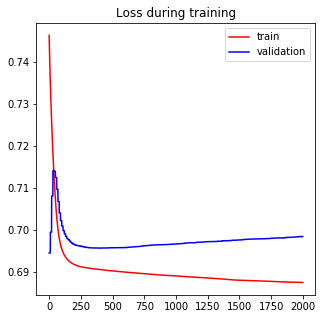

In [15]:
plt.figure(figsize=(5,5))
plt.plot(train_loss, 'r',label='train')
plt.plot(val_loss, 'b', label='validation')
plt.title('Loss during training')
plt.legend()#loc='upper right')
plt.show()

### IV. `TFFrozenModel` class

After the training&validation are done we saved our model. We can use the saved model for inference. Create TFFrozenModel instance:

In [16]:
#reset the default graph to avoid the errors
tf.reset_default_graph()

#create `TFFrozenModel` instance
frozen_model = TFFrozenModel(unet, logits2pred=softmax, restore_model_path='train')

img = generate_image(shape)
y_pred = frozen_model.do_inf_step([img])

#close the session
frozen_model.session.close()

INFO:tensorflow:Restoring parameters from train/model


In [17]:
print('Output shape: ', y_pred.shape)

Output shape:  (1, 2, 28, 28)


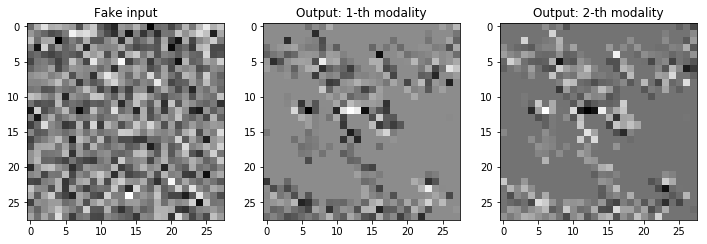

In [18]:
plt.figure(figsize=(3*4,2*4))
plt.subplot(131)
plt.imshow(img[0,...], cmap='gray')
plt.title('Fake input')
plt.subplot(132)
plt.title('Output: 1-th modality')
plt.imshow(y_pred[0, 0, ...], cmap='gray')
plt.subplot(133)
plt.title('Output: 2-th modality')
plt.imshow(y_pred[0, 1, ...], cmap='gray')
plt.show()